In [3]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense,Flatten,Reshape,Lambda,LeakyReLU,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K 
from tensorflow.keras import Model
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers.merge import concatenate as concat
import seaborn as sns

2.2.0-rc3


Using TensorFlow backend.


In [3]:
df_gal = pd.read_csv('MyTable_Galaxy_Dato1998.csv') #load the SDSS spectroscopic data
df_gal = df_gal.fillna('None')

In [4]:
for col in ['mag_g','mag_r','mag_i','mag_z']: #clean the data
    df_gal=df_gal.where(df_gal[col] >-1000)
df_gal = df_gal.dropna()

In [6]:
df_gal=df_gal.where(df_gal['cls'] == 'GALAXY') #choose galaxies only
df_gal = df_gal.dropna()

In [9]:
features = df_gal[['mag_g','mag_r','mag_i','mag_z']].to_numpy() #select features

In [10]:
targets = df_gal[['z','mass']].to_numpy() #select labels

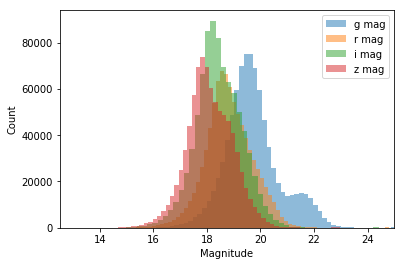

In [11]:
#Plot of magnitudes in SDSS dataset
for col in range(4):
     plt.hist(np.transpose(features)[col], alpha=0.5, bins =100)

plt.xlabel('Magnitude')
plt.xlim(12.5,25)
plt.ylabel('Count')
plt.legend(['g mag','r mag','i mag','z mag'])
plt.show()

In [12]:
#train-validation-test split
x_train = features[:round(len(features)*0.8)]
y_train = targets[:round(len(targets)*0.8)]
x_valid = features[round(len(features)*0.8):-1000]
y_valid = targets[round(len(targets)*0.8):-1000]
x_test = features[-1000:]
y_test = targets[-1000:]

In [14]:
X_train = np.copy(x_train)
X_valid = np.copy(x_valid)

In [15]:
#function for producing sampled latent variables to  be used in the end of the encoder
def sampling(args):
    mean, log_var = args
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2)+mean

In [16]:
#get the shapes of features and targets
n_x = x_train.shape[1]
n_y = y_train.shape[1]

In [17]:
X = Input(shape=[n_x,])
label = Input(shape=[n_y,])


In [18]:
coding_size = 10 #choose codings size
#create the encoder
inputs = concat([X,label])
z= Dense(400,)(inputs)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z= Dense(350,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z= Dense(300,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z= Dense(250,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z= Dense(200,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z = Dense(150,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z = Dense(100,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
z = Dense(50,)(z)
z=BatchNormalization()(z)
z = LeakyReLU()(z)
mean = Dense(coding_size)(z)
gamma = Dense(coding_size)(z)
codings = Lambda(sampling)([mean, gamma])
cvae_encoder = Model(inputs = [X,label], outputs = [codings])

In [19]:
#create the decoder
decoder_input = Input(shape=[coding_size+n_y])
x = Dense(50, )(decoder_input)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(100)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(150)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(200)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(250)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(300)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(350)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(400)(x)
x=BatchNormalization()(x)
x = LeakyReLU()(x)
outputs = Dense(n_x)(x)

cvae_decoder = Model(inputs=[decoder_input], outputs = [outputs])

In [20]:
#link up the encoder and decoder into a cVAE
codings = cvae_encoder([X,label])
ccodings = concat([codings, label])
reconstructions = cvae_decoder(ccodings)
cvae = Model(inputs=[X,label], outputs = [reconstructions])

In [21]:
latent_loss = -0.5 * K.sum(1+gamma - K.exp(gamma)-K.square(mean),axis = 1) #Add KL divergence 
cvae.add_loss(K.mean(latent_loss)/784)
cvae.compile(loss ='mean_squared_error', optimizer = 'rmsprop') #Choose loss and optimiser

In [22]:
mcp_save = ModelCheckpoint('./.cvae_galaxy.hdf5', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)#Lowest validation loss model is saved

Train on 683974 samples, validate on 169994 samples
Epoch 1/50
683974/683974 [==============================] - 133s 195us/sample - loss: 0.0694 - val_loss: 0.1313
Epoch 2/50
683974/683974 [==============================] - 131s 192us/sample - loss: 0.0622 - val_loss: 0.0390
Epoch 3/50
683974/683974 [==============================] - 137s 200us/sample - loss: 0.0571 - val_loss: 0.1267
Epoch 4/50
683974/683974 [==============================] - 141s 207us/sample - loss: 0.0532 - val_loss: 0.0582
Epoch 5/50
683974/683974 [==============================] - 139s 204us/sample - loss: 0.0497 - val_loss: 0.0796
Epoch 6/50
683974/683974 [==============================] - 141s 206us/sample - loss: 0.0473 - val_loss: 0.0472
Epoch 7/50
683974/683974 [==============================] - 141s 206us/sample - loss: 0.0447 - val_loss: 0.0749
Epoch 8/50
683974/683974 [==============================] - 135s 197us/sample - loss: 0.0432 - val_loss: 0.0283
Epoch 9/50
683974/683974 [==========================

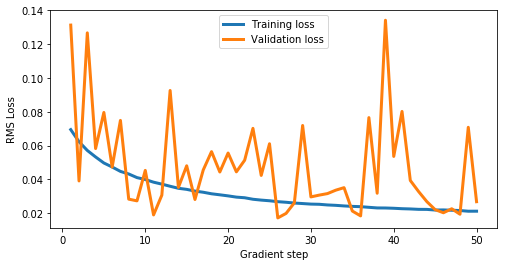

In [24]:
#train cVAE
history = cvae.fit([x_train,y_train], x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=([x_valid,y_valid], x_valid),
                callbacks=[mcp_save] )
epochs = range(1, len(history.history["loss"])+1)
plt.figure(1, figsize=(8,4))
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Gradient step"), plt.ylabel("RMS Loss");
plt.legend()
#Keep plot window alive!
plt.show()

In [25]:
cvae.load_weights(filepath="./.cvae_galaxy.hdf5") #load the cVAE with best weights

In [26]:
#generate data using the withheld test set
n=1000
labels = y_test
new_codings = np.random.normal(size=[n,coding_size])
new = np.concatenate([new_codings, labels],axis=-1)
new = tf.convert_to_tensor(new, dtype=tf.float32)
galaxies = cvae_decoder(new).numpy()
np.save('X.npy', x_test)
np.save('Y.xyz', new)

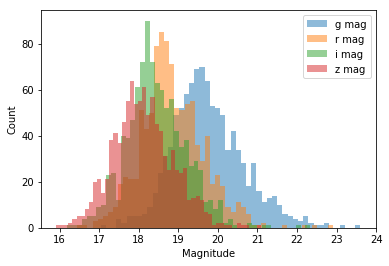

In [31]:
#plot of magintudes of generated data
for col in range(4):
     plt.hist(np.transpose(galaxies)[col], alpha=0.5,bins=50)

plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.legend(['g mag','r mag','i mag','z mag'])
plt.show()

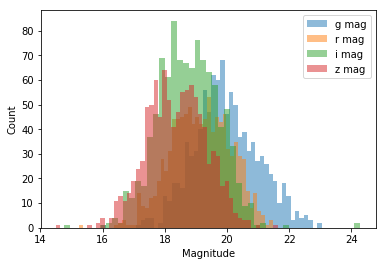

In [32]:
#plot of magnitudes of 1000 SDSS data points
for col in range(4):
     plt.hist(np.transpose(x_test)[col], alpha=0.5, bins =50)

plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.legend(['g mag','r mag','i mag','z mag'])
plt.show()

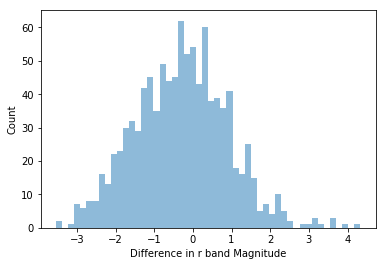

In [33]:
#Plot difference in r band magnitude
plt.hist(np.transpose(galaxies)[1]-np.transpose(x_test)[1], alpha=0.5,bins=50)
plt.xlabel('Difference in r band Magnitude')
plt.ylabel('Count')
plt.show()

In [34]:
df = pd.read_csv('HSC_big.csv') #load in HSC data
df = df.dropna()

In [35]:
df['stellar_mass'] = np.log10(df['stellar_mass'])

c:\users\dato\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [36]:
test = df[['stellar_mass','specz_redshift']].to_numpy() #take labels

In [37]:
n=len(test)
labels = test
new_codings = np.random.normal(size=[n,coding_size])
new = np.concatenate([new_codings, labels],axis=-1)
new = tf.convert_to_tensor(new, dtype=tf.float32)
galaxies = cvae_decoder(new).numpy() #generate data using HSC labels

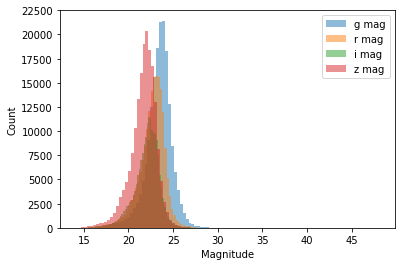

In [38]:
#plot HSC data to be reproduces
for col in ['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag']:
    plt.hist(df[col],bins=100,alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Magnitude')
plt.legend(['g mag','r mag','i mag','z mag'])

c:\users\dato\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\dato\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


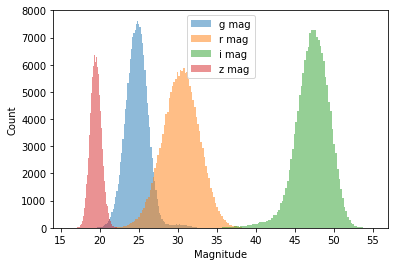

In [39]:
#Plot generated data
for col in range(4):
     plt.hist(np.transpose(galaxies)[col], alpha=0.5,bins=100)
plt.legend(['g mag','r mag','i mag','z mag'])
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()